#Project: Machine Learning
##Title: **COVID-19 DETECTION USING CNN**
### Submitted By: **Muhammad Hasnain Ali**
### Registration No: **CU/FA18-BCS-117/ISB**
### Date: June 14, 2021

### **Importing Libraries**

In [3]:
import pandas as pd
import os
#using glob library available in python we will retrieve filenames matched with specific pattern
#and then using shutil library which is used for copying, deleting and to perform mostly file operations
import glob
import shutil
import matplotlib.pyplot as plt
import numpy as np
# we are using watnings library to avoid any warning we recieve:
# normally when some method or usage of method when they are deprecated.
import warnings
warnings.filterwarnings("ignore")
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import preprocess_input, ResNet50
from keras.models import Model
from keras.layers import Dense, MaxPool2D, Conv2D, Dropout, Flatten
import keras
from keras.applications.vgg16 import VGG16 


In [ ]:
#We are using this link to fetch data directly from drop box
#the data will be in zip file
!wget https://www.dropbox.com/s/e1r2laj50nh4tez/COVID-19_Radiography_Dataset.zip?dl=0

In [ ]:
# we will now unzip dataset and save it to google colab file strucutre
!unzip "/content/COVID-19_Radiography_Dataset.zip?dl=0"

### **We have four types of images available**

1.   Normal
2.   Penuomonial
3.   Covid
4.   Lungs Opacity

### Let's Display details about data

In [6]:
covid_imgs = pd.read_excel("./COVID-19_Radiography_Dataset/COVID.metadata.xlsx")
covid_imgs.head(5)

,FILE NAME,FORMAT,SIZE,URL
0,COVID-1,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
1,COVID-2,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
2,COVID-3,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
3,COVID-4,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
4,COVID-5,PNG,256*256,https://sirm.org/category/senza-categoria/covi...


In [7]:
lungs_imgs = pd.read_excel("./COVID-19_Radiography_Dataset/Lung_Opacity.metadata.xlsx")
lungs_imgs.head(2)

,FILE NAME,FORMAT,SIZE,URL
0,Lung_Opacity-1,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
1,Lung_Opacity-2,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...


In [8]:
normal_images = pd.read_excel("./COVID-19_Radiography_Dataset/Normal.metadata.xlsx")
normal_images.head(2)

,FILE NAME,FORMAT,SIZE,URL
0,NORMAL-1,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
1,NORMAL-2,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...


In [9]:
pneumonia_images = pd.read_excel("./COVID-19_Radiography_Dataset/Viral Pneumonia.metadata.xlsx")
pneumonia_images.head(2)

,FILE NAME,FORMAT,SIZE,URL
0,Viral Pneumonia-1,PNG,256*256,https://www.kaggle.com/paultimothymooney/chest...
1,Viral Pneumonia-2,PNG,256*256,https://www.kaggle.com/paultimothymooney/chest...


### **We are now doing some pre processing on images, organizing them in single folder**

In [10]:
ROOT_DIR = "/content/COVID-19_Radiography_Dataset/" #this is the root directory from which we will fetch data
imgs = ['COVID','Lung_Opacity','Normal','Viral Pneumonia'] #this is list which contains categories of images
NEW_DIR = "/content/assets/" #this is our new folder (assets) it will contain all images, and inside this folder
#we will organize images in categories we described above

In [11]:
# First we will check if NEW_DIR already exists then we will throw an exception else we will create it 
if not os.path.exists(NEW_DIR):
  os.mkdir(NEW_DIR)
#then we will iterate over categories images and create new directory inside Root directory of type categories
  for i in imgs:
    org_dir = os.path.join(ROOT_DIR, i+"/")
    #using glob library available in python we will retrieve filenames matched with specific pattern
    #and then using shutil library which is used for copying, deleting and to perform mostly file operations
    for imgfile in glob.iglob(os.path.join(org_dir, "*.png")):
      shutil.copy(imgfile, NEW_DIR)
      
else:
  print("Already Exist")

### **Let's Now Check how many images do we have related to each category**

In [13]:
totalImages = {'COVID':0,'Lung_Opacity':0,'Normal':0,'Viral Pneumonia':0}

for image in imgs:
  for eachImage in glob.iglob(NEW_DIR+image+"*"):
    totalImages[image] += 1
totalImages

{'COVID': 3616, 'Lung_Opacity': 6012, 'Normal': 10192, 'Viral Pneumonia': 1345}

### **Now Lets Visualize total images of specific categories using bar plot**

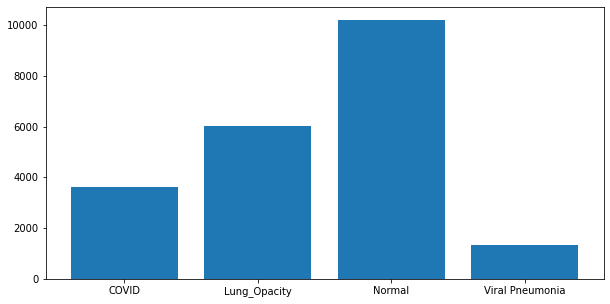

In [14]:
plt.figure(figsize=(10,5))
plt.bar(x = totalImages.keys(), height= totalImages.values())
plt.show()

## **Splitting Data in training, testing and validation sets**

In [15]:
#lets create a directory which will contain training testing data
#we will name this directory as train_test_split and  firstly will check whether directory pre exists 
#if so we will throw an exception else we will proceed
if not os.path.exists(NEW_DIR+"train_test_split/"):

  os.makedirs(NEW_DIR+"train_test_split/")

  os.makedirs(NEW_DIR+"train_test_split/train/Normal")
  os.makedirs(NEW_DIR+"train_test_split/train/Covid")

  os.makedirs(NEW_DIR+"train_test_split/test/Normal")
  os.makedirs(NEW_DIR+"train_test_split/test/Covid")

  os.makedirs(NEW_DIR+"train_test_split/validation/Normal")
  os.makedirs(NEW_DIR+"train_test_split/validation/Covid")


  # We will add train images in Train subdirectory inside train_test_split directory
  for i in np.random.choice(replace= False , size= 3000 , a = glob.glob(NEW_DIR+imgs[0]+"*") ):
    shutil.copy(i , NEW_DIR+"train_test_split/train/Covid" )
    os.remove(i)

  for i in np.random.choice(replace= False , size= 3900 , a = glob.glob(NEW_DIR+imgs[2]+"*") ):
    shutil.copy(i , NEW_DIR+"train_test_split/train/Normal" )
    os.remove(i)

  for i in np.random.choice(replace= False , size= 900 , a = glob.glob(NEW_DIR+imgs[3]+"*") ):
    shutil.copy(i , NEW_DIR+"train_test_split/train/Covid" )
    os.remove(i)

  # # We will add validation set  images in validation data  subdirectory inside train_test_split directory
  for i in np.random.choice(replace= False , size= 308 , a = glob.glob(NEW_DIR+imgs[0]+"*") ):
    shutil.copy(i , NEW_DIR+"train_test_split/validation/Covid" )
    os.remove(i)

  for i in np.random.choice(replace= False , size= 500 , a = glob.glob(NEW_DIR+imgs[2]+"*") ):
    shutil.copy(i , NEW_DIR+"train_test_split/validation/Normal" )
    os.remove(i)

  for i in np.random.choice(replace= False , size= 200 , a = glob.glob(NEW_DIR+imgs[3]+"*") ):
    shutil.copy(i , NEW_DIR+"train_test_split/validation/Covid" )
    os.remove(i)

  # # We will add test set images in test subdirectory inside train_test_split directory
  for i in np.random.choice(replace= False , size= 300 , a = glob.glob(NEW_DIR+imgs[0]+"*") ):
    shutil.copy(i , NEW_DIR+"train_test_split/test/Covid" )
    os.remove(i)

  for i in np.random.choice(replace= False , size= 300 , a = glob.glob(NEW_DIR+imgs[2]+"*") ):
    shutil.copy(i , NEW_DIR+"train_test_split/test/Normal" )
    os.remove(i)

  for i in np.random.choice(replace= False , size= 200 , a = glob.glob(NEW_DIR+imgs[3]+"*") ):
    shutil.copy(i , NEW_DIR+"train_test_split/test/Covid" )
    os.remove(i)

### **Now let's start working on CNN implementation**
All of preprocessing on data has been completed

In [16]:
#Below are the paths from which we fetch data for training and testing
train_path  = "/content/assets/train_test_split/train"
valid_path  = "/content/assets/train_test_split/validation"
test_path   = "/content/assets/train_test_split/test"

### We will use data generators to import data because data generators helps in image augmentations which basically helps us in changing properties of images like flip it horizontally or we can perform various operations. So that model learns well.

In [17]:
train_data_generators = ImageDataGenerator(preprocessing_function= preprocess_input, 
                                    zoom_range= 0.2, 
                                    horizontal_flip= True, 
                                    shear_range= 0.2,
                                    
                                    )

train_data = train_data_generators.flow_from_directory(directory= train_path, 
                                           target_size=(224,224))

Found 7800 images belonging to 2 classes.


### lets Now make generators for validation data set


In [18]:
validation_data_generators = ImageDataGenerator(preprocessing_function= preprocess_input  )

validation_data = validation_data_generators.flow_from_directory(directory= valid_path, 
                                                target_size=(224,224))

Found 1008 images belonging to 2 classes.


### lets Now make generators for validation data set


In [19]:
test_data_generators = ImageDataGenerator(preprocessing_function= preprocess_input )

test_data = train_data_generators.flow_from_directory(directory= test_path , 
                                          target_size=(224,224), 
                                          shuffle= False)

Found 800 images belonging to 2 classes.


### For the sake of simplicity we will just have binary classification that is class 0 for a covid patient and 1 for a normal patient 

In [20]:
class_label = {0:'Covid', 1:'Normal'}

## **Let's Visualize Some images**

In [21]:
#fetch some images from train data 
train_imgs , label = train_data.next()

In [22]:
#this method will help in plotting images, it will recieve image array as an input
#and class label
def plotImage(img_arr, label):
  for img, lab in zip(img_arr,label) :
    plt.figure(figsize= (5,5))
    plt.imshow(img, cmap = 'gray')
    plt.title(img.shape)
    plt.axis = False
    plt.show()

In [ ]:
#lets now call this method and plot train_data images
plotImage(train_imgs, label)

### We will use **VGG 16** as a modal structure for detective covid-19
### VGG-16 is a convolution neural net (CNN ) architecture which was used to win ILSVR(Imagenet) competition in 2014. It is considered to be one of the excellent vision model architecture till date. ... It follows this arrangement of convolution and max pool layers consistently throughout the whole architecture.
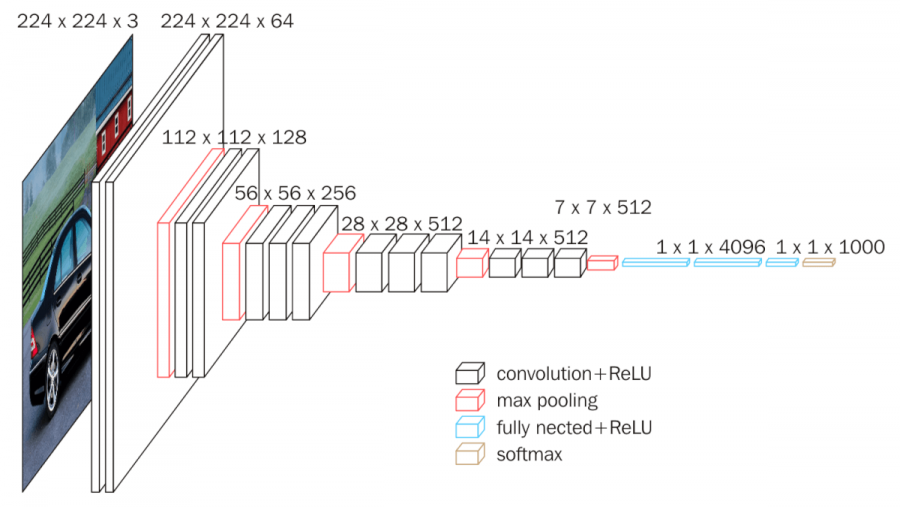

In [24]:
vgg = VGG16( input_shape=(224,224,3), include_top= False) # include_top will consider the new weights

58900480/58889256 [==============================] - 1s 0us/step


In [25]:
for layer in vgg.layers:           # Dont Train the parameters again, that's why setting layer.trainable = false
  layer.trainable = False

In [26]:
#Now we will flatten our vgg output and then we will use Dense Function where we apply activation function as sigmoid
x = Flatten()(vgg.output)
x = Dense(units=2 , activation='sigmoid', name = 'predictions' )(x)

model = Model(vgg.input, x)

In [27]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

**Compiling Model**

In [28]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

In [29]:
# implementing early stopping and model check point 
# Use of early stopping is that if we are using large number of epochs and at some
# point accuracy of model stops improving then at that point, model will be considered
# as best model.
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

es = EarlyStopping(monitor= "val_accuracy" , min_delta= 0.01, patience= 3, verbose=1)
mc = ModelCheckpoint(filepath="optimizedModel.h5", monitor="val_accuracy", verbose=1, save_best_only= True)

In [40]:
model = model.fit_generator(train_data, steps_per_epoch= 10, epochs= 10, validation_data= validation_data , validation_steps= 32, callbacks=[es,mc])

Epoch 1/10
10/10 [==============================] - 690s 75s/step - loss: 3.6377 - accuracy: 0.8344 - val_loss: 2.0490 - val_accuracy: 0.8581

Epoch 00001: val_accuracy did not improve from 0.87401
Epoch 2/10
10/10 [==============================] - 684s 74s/step - loss: 1.5231 - accuracy: 0.8844 - val_loss: 3.9506 - val_accuracy: 0.7857

Epoch 00002: val_accuracy did not improve from 0.87401
Epoch 3/10
10/10 [==============================] - 681s 74s/step - loss: 2.0729 - accuracy: 0.8313 - val_loss: 3.3599 - val_accuracy: 0.8075

Epoch 00003: val_accuracy did not improve from 0.87401
Epoch 4/10
10/10 [==============================] - 677s 73s/step - loss: 1.8351 - accuracy: 0.8406 - val_loss: 1.3356 - val_accuracy: 0.8938

Epoch 00004: val_accuracy improved from 0.87401 to 0.89385, saving model to optimizedModel.h5
Epoch 5/10
10/10 [==============================] - 678s 73s/step - loss: 1.2782 - accuracy: 0.8938 - val_loss: 2.2245 - val_accuracy: 0.8542

Epoch 00005: val_accuracy 

# **Modal Stats**

## **Let's Find Accuracy Of Model**

In [55]:
accuracy = model.evaluate_generator(generator= test_data)[1] 
print(f"The accuracy of your model is = {accuracy} %")

The accuracy of your model is = 0.8687499761581421 %


## **Prediction Time**

In [56]:
from keras.preprocessing import image
def get_Tensor(imgPath):
  path = imgPath
  img = image.load_img(path, target_size=(224,224,3))
  img = image.img_to_array(img)/255
  img = np.expand_dims(img , axis= 0 )
  
  return img

The given X-Ray image is of type = Covid

The chances of being Covid is : 98.02181124687195 percent

The chances of being Normal is : 0.5939364433288574 percent


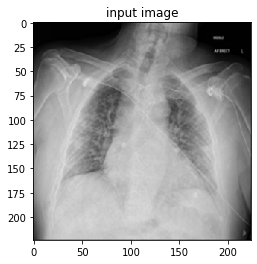

In [60]:
#path can be taken as local source image or from google no restriction here
path = "/content/assets/COVID-1037.png"       # you can add any image path

img = get_Tensor(path)

res = class_label[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}\n")
print(f"The chances of being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of being Normal is : {model.predict(img)[0][1]*100} percent")

# to display the image  
plt.imshow(img[0], cmap = "gray")
plt.title("input image")
plt.show()